# a first simplified 2D barotropic model
Use FFT in periodic 2D domain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


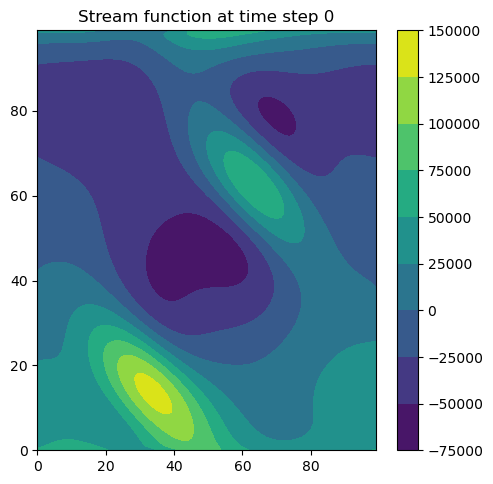

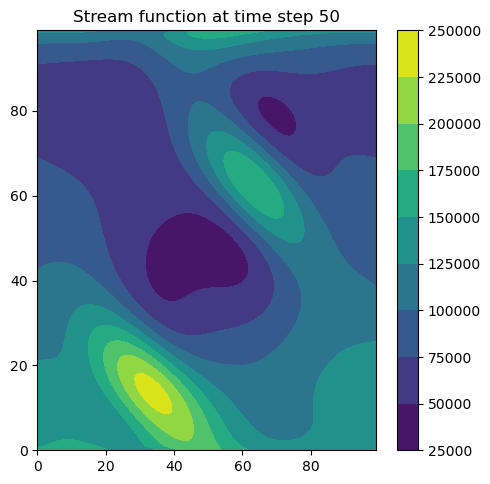

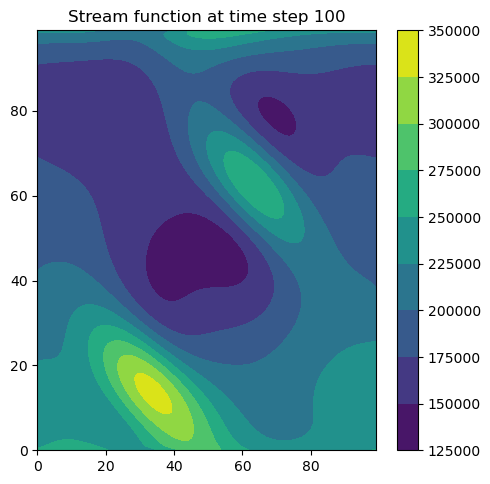

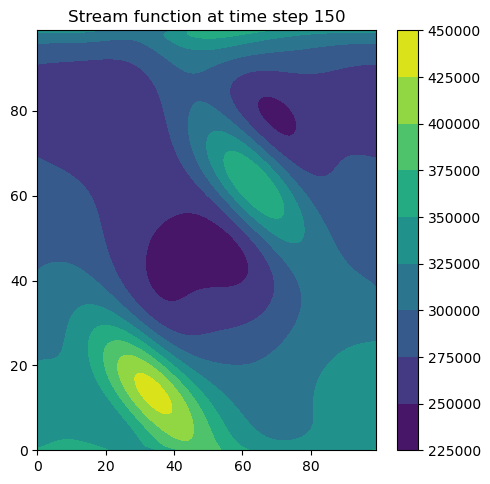

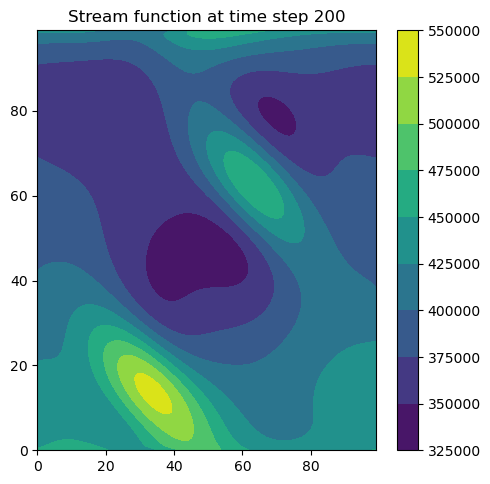

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fft import fft2, ifft2
from scipy.misc import derivative
import math as mt

%load_ext autoreload
%autoreload 1
%matplotlib inline
#%matplotlib notebook

def plot_model(psi, timestep):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(2,2,1)
    h1=ax.contourf(np.real(psi))
    ax.set_title(f'Stream function at time step {timestep}')
    fig.colorbar(h1)
    plt.show()
    return

N = 100
T = 201
deltaT = 1000
Tplot = 50
beta = 0.1

x = np.linspace(0, 2*mt.pi, N)
y = np.linspace(0, 2*mt.pi, N)
x, y = np.meshgrid(x, y)

def multivariate_gaussian(pos, mu, sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N = np.sqrt((2*np.pi)**n * sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# initialization

# Mean vector and covariance matrix
mu = np.array([2., 1.])
sigma = np.array([[ 1. , -0.5], [-0.5,  1.]])

# Pack x and y into a single 3-dimensional array
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Mean vector and covariance matrix
mu1 = np.array([4., 4.])
sigma1 = np.array([[ 1. , -0.5], [-0.5,  1.]])

# Pack x and y into a single 3-dimensional array
pos1 = np.empty(x.shape + (2,))
pos1[:, :, 0] = x
pos1[:, :, 1] = y

psi = multivariate_gaussian(pos, mu, sigma) - multivariate_gaussian(pos1, mu1, sigma1)

#plt.pcolor(x,y,np.real(psi))

A = np.zeros((N,N), dtype=complex)
dAdx_fft = np.zeros((N,N), dtype=complex)
B = np.zeros((N,N), dtype=complex)
dBdx_fft = np.zeros((N,N), dtype=complex)

zeta_fft = np.zeros((N,N), dtype=complex)
u_fft = np.zeros((N,N), dtype=complex)
v_fft = np.zeros((N,N), dtype=complex)


for t in np.arange(0,T):
    psi_fft = fft2(psi)
    for k in np.arange(0,N):
        for l in np.arange(0,N):
            zeta_fft[k,l] = (-k**2 - l**2)*psi_fft[k,l]
            u_fft[k,l] = -1j*l*psi_fft[k,l]
            v_fft[k,l] = 1j*k*psi_fft[k,l]
    
    zeta = ifft2(zeta_fft)
    u = ifft2(u_fft)
    v = ifft2(v_fft)
    for i in np.arange(0,N):
        for j in np.arange(0,N):
            A[i,j] = -u[i,j]*zeta[i,j]
            B[i,j] = v[i,j]*zeta[i,j]
    
    A_fft = fft2(A)
    B_fft = fft2(B)
    for k in np.arange(0,N):
        for l in np.arange(0,N):
            dAdx_fft[k,l] = 1j*k*A_fft[k,l]
            dBdx_fft[k,l] = 1j*k*B_fft[k,l]
    
    dAdx = ifft2(dAdx_fft)
    dBdx = ifft2(dBdx_fft)
    
    f = -dAdx - dBdx - psi*beta
    
    if t == 0:
        # forward scheme
        zeta = zeta + deltaT*f
    else:
        zeta = 2*deltaT + previous_zeta
        
    previous_zeta = zeta    
    zeta_fft = fft2(zeta)
    
    for k in np.arange(0,N):
        for l in np.arange(0,N):
            if k == 0 and l == 0:
                psi_fft[k,l] = zeta_fft[k,l]
            else:
                psi_fft[k,l] = zeta_fft[k,l]/(-k**2-l**2)
    psi = ifft2(psi_fft)
    
    if t%Tplot == 0:
        plot_model(psi, t)
    
#plt.pcolor(x,y,np.real(psi))
